# Stock Market Detection Wyckoff using Machine Learning

## 🧩 Cell 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# กำหนดสไตล์การแสดงผลกราฟ
plt.style.use('dark_background')

## 🧩 Cell 2: ฟังก์ชันดึงข้อมูลจาก Cassandra

In [2]:
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    df.rename(columns={'open_price': 'open', 'high_price': 'high', 'low_price': 'low', 'close_price': 'close'}, inplace=True)
    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    # แปลงข้อมูลเป็น float
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

## 🧩 Cell 3: เตรียมข้อมูลสำหรับ LSTM

In [3]:
def create_sequences_and_labels(data, seq_length=15):
    """
    เตรียมข้อมูลราคาหุ้นให้อยู่ในรูปแบบที่ LSTM ต้องการ (3D: Samples, Timesteps, Features)
    และสร้าง Target Label สำหรับการคาดการณ์ทิศทาง (1 = ขึ้น, 0 = ลง/คงที่)
    """
    # 1. สร้าง Target Label: 1 ถ้า Close Price ของวันถัดไปสูงกว่าวันนี้, 0 ถ้าต่ำกว่าหรือเท่ากับ
    data['target_direction'] = np.where(data['close'].shift(-1) > data['close'], 1, 0)
    data = data.dropna() 

    features = data[['open', 'high', 'low', 'close', 'volume']].values
    labels = data['target_direction'].values

    # 2. Scaling (ปรับขนาดข้อมูล)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    X, y = [], []
    for i in range(seq_length, len(scaled_features)):
        X.append(scaled_features[i - seq_length:i, :])
        y.append(labels[i])
        
    return np.array(X), np.array(y), scaler, data.index[seq_length:]

## 🧩 Cell 4: สร้างและฝึกโมเดล LSTM

In [4]:
# 3️⃣ ฟังก์ชันสร้างและฝึกโมเดล LSTM
def build_and_train_lstm(X_train, y_train, seq_length, num_features):
    """สร้างโมเดล LSTM สำหรับการจำแนกทิศทาง (Classification)"""
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(seq_length, num_features)),
        Dropout(0.2),
        
        # LSTM Layer ที่สอง
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        
        Dense(units=1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    print("--- Training LSTM Model ---")
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    print("--- Training Complete ---")
    
    return model

## 🧩 Cell 5: ฟังก์ชันทำนายทิศทาง

In [5]:
def predict_direction(model, X_test):
    """ทำนายทิศทางราคา และแปลงผลลัพธ์จาก 0-1 เป็นทิศทาง (Up/Down)"""
    # ทำนายผลลัพธ์ (ความน่าจะเป็นที่ราคาจะขึ้น)
    predictions = model.predict(X_test, verbose=0)
    
    # แปลงความน่าจะเป็นเป็นทิศทาง (0 หรือ 1)
    predicted_classes = (predictions > 0.5).astype(int)
    
    return predicted_classes.flatten()

## 🧩 Cell 6: ฟังก์ชันวาดกราฟผลการทำนาย

In [6]:
def plot_lstm_forecast(dates, actual_prices, predicted_direction, symbol='SYMBOL', forecast_days=10):

    start_idx = max(0, len(dates) - 100)
    
    plot_dates_index = dates[start_idx:]
    plot_dates = pd.Series(plot_dates_index) 
    
    plot_prices = actual_prices[start_idx:]
    plot_direction = predicted_direction[len(predicted_direction) - len(plot_dates):] 
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 1. Plot ราคาจริง
    ax.plot(plot_dates, plot_prices, label='Actual Close Price', color='dodgerblue', linewidth=2)
    
    # 2. Mark จุดเริ่มต้นการคาดการณ์ (10 วันสุดท้าย)
    forecast_start_date = plot_dates.iloc[-forecast_days]
    ax.axvline(forecast_start_date, color='yellow', linestyle='-', linewidth=2, label='Forecast Start Date', zorder=5)

    for i in range(len(plot_dates) - forecast_days, len(plot_dates) - 1):
        current_date = plot_dates.iloc[i] 
        next_date = plot_dates.iloc[i+1]
        
        current_price = plot_prices[i] 
        next_price = plot_prices[i+1] 

        direction = plot_direction[i]
        
        # กำหนดสีตามทิศทางที่คาดการณ์
        line_color = 'red' if direction == 0 else 'lime' 

        # ลากเส้นคาดการณ์ 
        ax.plot([current_date, next_date], [current_price, next_price], 
                color=line_color, linestyle='--', linewidth=3, alpha=0.7, zorder=4)
                
        # Annotate ทิศทาง

        mid_date = current_date + (next_date - current_date) / 2 
        mid_price = (current_price + next_price) / 2
        ax.annotate('Up' if direction == 1 else 'Down', 
                    (mid_date, mid_price * 1.001), 
                    color='white', fontsize=8, ha='center', va='bottom', 
                    bbox=dict(facecolor=line_color, alpha=0.8, boxstyle="round,pad=0.3"))


    ax.set_title(f"{symbol} - LSTM Direction Forecast ({forecast_days} Days Ahead)", color='white', fontsize=16, pad=20)
    ax.set_xlabel("Date", color='white', fontsize=12)
    ax.set_ylabel("Price", color='white', fontsize=12)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    
    # จัดการ Legend ให้ไม่ซ้ำกัน
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), facecolor='black', edgecolor='white', loc='upper left')

    plt.tight_layout()
    plt.show()

## 🧩 Cell 7: ส่วน Execution (รันจริง)

1. ดึงข้อมูล BTC (Limit: 300 วัน)...

2. เตรียมข้อมูล LSTM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Training LSTM Model ---
--- Training Complete ---

4. ประเมินและทำนายทิศทาง...
   Accuracy (Test Set): 0.7222

5. แสดงกราฟ LSTM Direction Forecast...


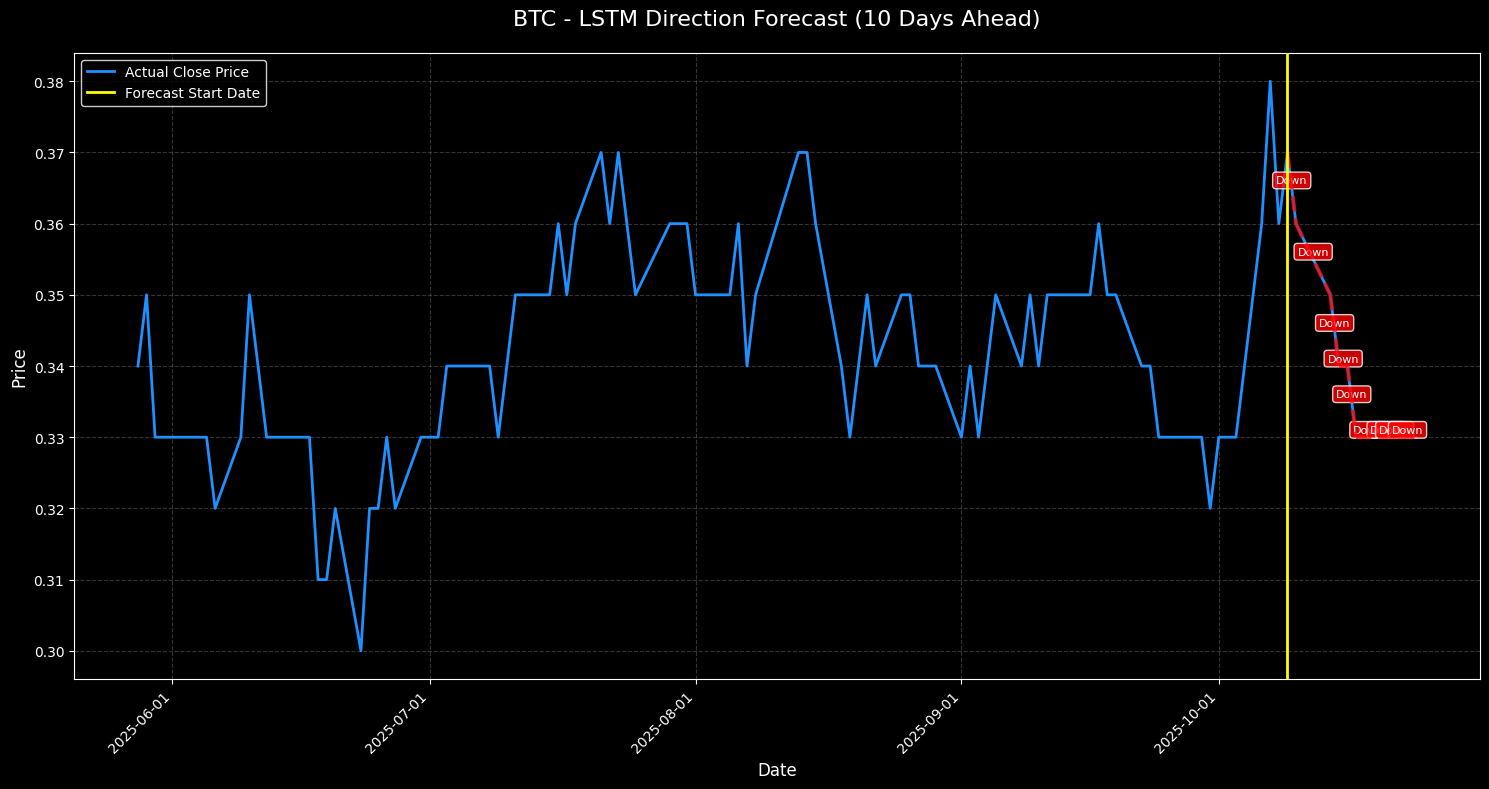

In [7]:
try:
    symbol = "BTC" 
    DATA_LIMIT = 300  
    SEQUENCE_LENGTH = 30 
    TRAIN_SPLIT = 0.8  
    
    print(f"1. ดึงข้อมูล {symbol} (Limit: {DATA_LIMIT} วัน)...")
    df = get_candlestick_data(symbol, limit=DATA_LIMIT)
    
    # 2. เตรียมข้อมูลสำหรับ LSTM
    print("\n2. เตรียมข้อมูล LSTM...")
    X, y, scaler, dates = create_sequences_and_labels(df.copy(), seq_length=SEQUENCE_LENGTH)
    
    # แบ่งข้อมูล Train/Test
    train_size = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # 3. สร้างและฝึกโมเดล LSTM
    num_features = X.shape[2]
    model = build_and_train_lstm(X_train, y_train, SEQUENCE_LENGTH, num_features)
    
    # 4. ทดสอบและคาดการณ์
    print("\n4. ประเมินและทำนายทิศทาง...")
    
    y_pred_test = predict_direction(model, X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"   Accuracy (Test Set): {accuracy:.4f}")
    
    y_pred_all = predict_direction(model, X)
    
    # 5. แสดงผลกราฟ
    print("\n5. แสดงกราฟ LSTM Direction Forecast...")
    actual_prices = df['close'][dates].values 
    plot_lstm_forecast(dates, actual_prices, y_pred_all, symbol=symbol, forecast_days=10)
    
except ConnectionRefusedError as e:
    print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
    print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
except ValueError as e:
    print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
except Exception as e:
    print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")
    print(f"Detail: {e}")